# Tutorial 9: Combining Models and Data with Direct Sums

In this tutorial, we'll explore the tools for working with **direct sums** of Hilbert spaces. This is a crucial feature for tackling complex inverse problems where you might have:
* A single model that is constrained by multiple, different types of data (a **joint inversion**).
* A model that is composed of multiple, distinct parts.

We will cover three main use cases:
1.  The basics of the `HilbertSpaceDirectSum` class.
2.  How to combine `GaussianMeasure`s using `GaussianMeasure.from_direct_sum`.
3.  How to set up and solve a **joint inverse problem**, visualizing the result and its uncertainty.

In [1]:
# To run in colab, uncomment the line below to install pygeoinf. 
#%pip install pygeoinf

import numpy as np
import matplotlib.pyplot as plt
import pygeoinf as inf
from pygeoinf.hilbert_space import EuclideanSpace
from pygeoinf.direct_sum import HilbertSpaceDirectSum

# For reproducibility
np.random.seed(0)

## 1. The `HilbertSpaceDirectSum`

A `HilbertSpaceDirectSum` is a space formed by combining a list of other spaces. A vector in this new space is simply a **list** of vectors, one from each of the component subspaces.

In [2]:
# Create the component spaces
space1 = EuclideanSpace(2)
space2 = EuclideanSpace(3)

# Create the direct sum space
direct_sum_space = HilbertSpaceDirectSum([space1, space2])

print(f"Dimension of space 1: {space1.dim}")
print(f"Dimension of space 2: {space2.dim}")
print(f"Dimension of direct sum space: {direct_sum_space.dim}")

# A vector in this space is a list of vectors
x = [np.array([1.0, 2.0]), np.array([3.0, 4.0, 5.0])]
print(f"\nA vector in the direct sum space:\n{x}")

# The component representation is the concatenation of the individual components
c = direct_sum_space.to_components(x)
print(f"\nComponent representation of the vector:\n{c}")

Dimension of space 1: 2
Dimension of space 2: 3
Dimension of direct sum space: 5

A vector in the direct sum space:
[array([1., 2.]), array([3., 4., 5.])]

Component representation of the vector:
[1. 2. 3. 4. 5.]


## 2. Direct Sums of Gaussian Measures

A common task is to define a probability distribution over a combined space where the components are independent. The `GaussianMeasure.from_direct_sum` method does exactly this.

In [3]:
# Create a Gaussian measure on space1
mean1 = np.array([1, 0])
cov1 = np.array([[1.0, 0.5], [0.5, 1.0]])
measure1 = inf.GaussianMeasure.from_covariance_matrix(space1, cov1, expectation=mean1)

# Create a Gaussian measure on space2
mean2 = np.array([0, 2, 0])
cov2 = np.array([[2.0, 0, 0], [0, 1.0, -0.3], [0, -0.3, 1.0]])
measure2 = inf.GaussianMeasure.from_covariance_matrix(space2, cov2, expectation=mean2)

# Combine them into a single product measure
product_measure = inf.GaussianMeasure.from_direct_sum([measure1, measure2])

# The expectation is a list of the individual expectations
print(f"Expectation of the product measure:\n{product_measure.expectation}")

# The covariance is a block-diagonal operator
print(f"\nCovariance of the product measure is of type: {type(product_measure.covariance)}")

# Let's check a sample
sample = product_measure.sample()
print(f"\nA sample from the product measure is a list:")
print(f"Component 1 (from measure1): {sample[0]}")
print(f"Component 2 (from measure2): {sample[1]}")

Expectation of the product measure:
[array([1, 0]), array([0, 2, 0])]

Covariance of the product measure is of type: <class 'pygeoinf.direct_sum.BlockDiagonalLinearOperator'>

A sample from the product measure is a list:
Component 1 (from measure1): [0.46452013 1.22857248]
Component 2 (from measure2): [2.64112584 0.77236334 2.38569506]


## 3. Application: A Joint Inverse Problem

The most powerful application of direct sums is in setting up a **joint inversion**. This is a scenario where we have one model `u` that we want to estimate, but we have measured its effects via two or more different physical experiments.

Let's imagine:
* Our **model** `u` is a smooth function on a circle.
* **Data 1**: We have 10 noisy point measurements of the function `u` itself.
* **Data 2**: We have 5 noisy point measurements of the **derivative** of the function, `du/dθ`.

We will combine these into a single problem and solve for the posterior distribution of `u`, including its uncertainty.

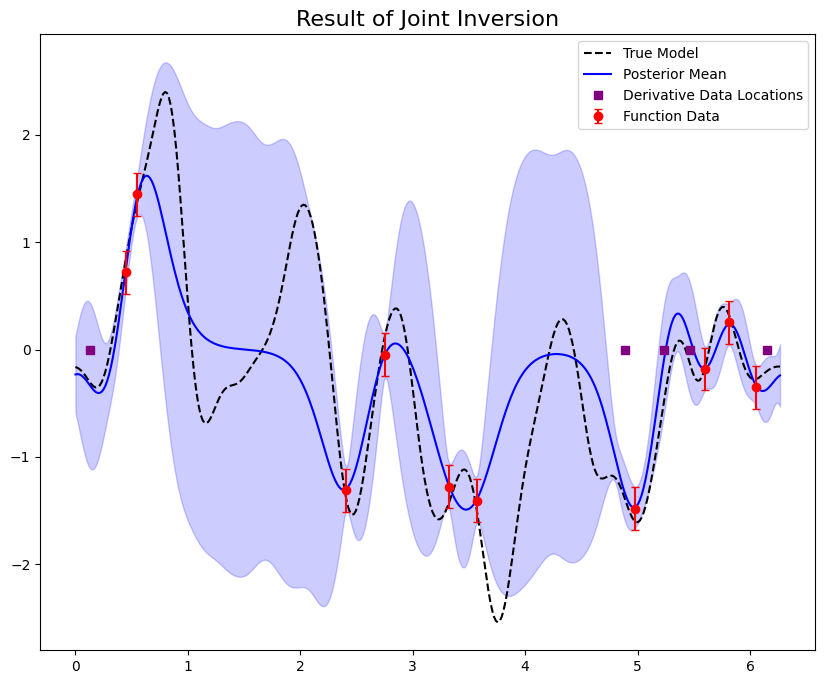

In [4]:
from pygeoinf.symmetric_space.circle import Sobolev

# --- Define the common model space ---
model_space = Sobolev.from_sobolev_parameters(2.0, 0.1)

# --- Problem 1: Measure the function itself ---
n_data1 = 10
obs_points1 = model_space.random_points(n_data1)
forward_op1 = model_space.point_evaluation_operator(obs_points1)
std = 0.1
data_error1 = inf.GaussianMeasure.from_standard_deviation(forward_op1.codomain, std)
problem1 = inf.LinearForwardProblem(forward_op1, data_error_measure=data_error1)

# --- Problem 2: Measure the function's derivative ---
n_data2 = 5
obs_points2 = model_space.random_points(n_data2)
# Create the forward operator A = (point_eval @ differentiation)
lebesgue_space = model_space.underlying_space
def diff_map(u):
    coeff = model_space.to_coefficient(u)
    k = np.arange(coeff.size)
    diff_coeff = 1j * k * coeff
    return model_space.from_coefficient(diff_coeff)
diff_op_L2 = inf.LinearOperator(lebesgue_space, lebesgue_space, diff_map,
                                adjoint_mapping = lambda u: -1 * diff_map(u))
diff_op = inf.LinearOperator.from_formal_adjoint(model_space, model_space, diff_op_L2)
forward_op2 = model_space.point_evaluation_operator(obs_points2) @ diff_op
data_error2 = inf.GaussianMeasure.from_standard_deviation(forward_op2.codomain, 0.05)
problem2 = inf.LinearForwardProblem(forward_op2, data_error_measure=data_error2)

# --- Create the Joint Problem ---
joint_problem = inf.LinearForwardProblem.from_direct_sum([problem1, problem2])

# --- Generate Data and Solve ---
prior = model_space.point_value_scaled_heat_kernel_gaussian_measure(scale=0.1)
true_model, joint_data = joint_problem.synthetic_model_and_data(prior)

inversion = inf.LinearBayesianInversion(joint_problem, prior)
solver = inf.CholeskySolver(galerkin=True)
posterior = inversion.model_posterior_measure(joint_data, solver)

# --- Estimate Posterior Uncertainty ---
low_rank_posterior = posterior.low_rank_approximation(10, method="variable", rtol=1e-4)
posterior_variance = low_rank_posterior.sample_pointwise_variance(200)
posterior_std = np.sqrt(posterior_variance)

# --- Plot the Final Result ---
fig, ax = model_space.plot(true_model, linestyle='--', color='k', label='True Model')
model_space.plot(posterior.expectation, fig=fig, ax=ax, color='b', label='Posterior Mean')

# Add uncertainty bounds
model_space.plot_error_bounds(
    posterior.expectation, 2 * posterior_std, fig=fig, ax=ax, color='b', alpha=0.2
)

# Add data points for function values
ax.errorbar(obs_points1, joint_data[0], yerr=2*std, 
            fmt='o', color='red', capsize=3, label='Function Data')

# Add markers for the locations of derivative measurements
ax.plot(obs_points2, np.zeros_like(obs_points2), 's', color='purple', 
        markersize=6, label='Derivative Data Locations')

ax.set_title("Result of Joint Inversion", fontsize=16)
ax.legend()
plt.show()